TO DO


*   Create new visualization in exploration
*   Try out different models and test sizes
*   Use all visualizations to test model (cost function, etc.)
*   Make sure the data always outputs the same thing.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Introduction

---

We will be build a credit card fraud detection model. The goals of this notebook are the following:



*   Show how to create a fraud detection system
*   Explain how to deal with imbalanced datasets
*   Use a wide variety of models to get a better understanding of which ones work better
*   Use Semi-Supervised Classification

---


Table of Contents

I. Understanding Our Data
1. Gather Sense of our Data

II. Preprocessing
1. Scaling and Distributing
2. Splitting the Data

III. Random Undersampling and Oversampling
1. Distributing and Correlation
2. Anomaly Detection
3. Dimensionality Reduction and Clustering (t-SNE)
4. Classifiers
5. A Deeper Look into Logistic Regression
6. Oversampling with SMOTE

IV. Testing
1. Testing with Logistic Regression
2. Neural Networks Testing (Undersamping vs Oversamping)

# Problem Statement:

Credit card fraud is a problem where some of the credit card transactions turn out to be fraud. Credit card companies would like to reduce the risks of fraud in order to reduce the costs associated. Our model's aim is to try to eliminate fraudulent transactions.

# Importing Libraries

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

#import zipfile
#with zipfile.ZipFile('/content/drive/My Drive/creditcard 2.csv.zip', 'r') as f:
#  f.extractall(path='/content/')

# Import Libraries

import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set(style="whitegrid")
import random
import tensorflow as tf
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.utils import shuffle
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
LABELS = ["Normal", "Fraud"]
import plotly
import time

# Classifier Libraries 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import collections

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

# Data Exploration

Let's load the data and check it out.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/creditcard.csv', low_memory=False) # import file
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The features are already scaled and the names of features are not shown due to privacy reasons.

Now, let's have a look at how many of the transactions are fraudulent.

In [ ]:
# loc locates all data by column or conditional statement
frauds = df.loc[df['Class'] == 1] # find all rows that are fraudulent
non_frauds = df.loc[df['Class'] == 0] # final all rows that aren't fraudulent
print('Frauds ', len(frauds), ' transactions or ', round(df['Class'].value_counts()[0]/len(df)*100, 2), '% of the dataset')
print('No Fraud ', len(non_frauds), ' transactions or ', round(df['Class'].value_counts()[1]/len(df)*100, 2), '% of the dataset')

Frauds  492  transactions or  99.83 % of the dataset
No Fraud  284315  transactions or  0.17 % of the dataset


Only 492 of the transactions are fraudulent. This means that the dataset is quite imbalanced; 99.83% of transactions are normal. The cases of fraud are anomalies and therefore our model will be doing anomaly detection to find out which transactions are fraudulent.

We do not want to use this dataframe as the base for our predictive models and analysis because we will get a lot of errors and our model will overfit since it will assume that most transactions are not fraud. This will require us to modify the dataframe quite a bit later on so that we can create a model that will properly predict (patterns of) fraud.

Let's have a look at some of the statistics regarding the dataset.

In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Let's have a look if there are any Null values:

In [ ]:
df.isnull().sum().max()

0

Perfect, no Null values!

## Let's Visualize the data

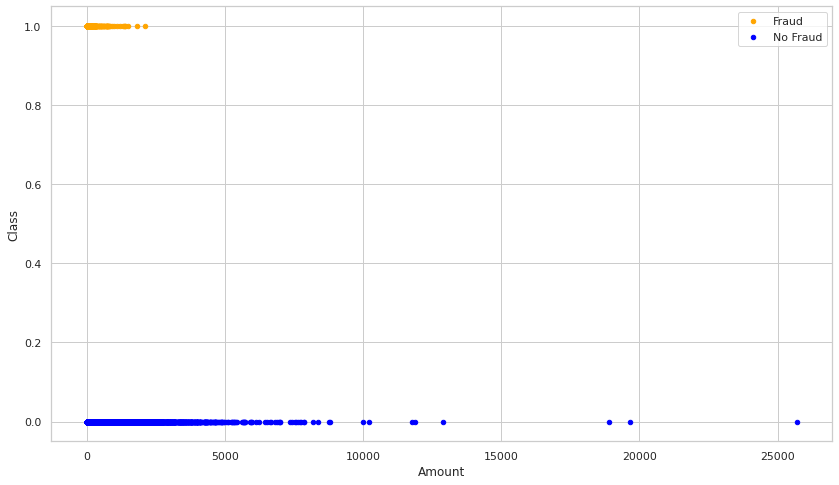

In [ ]:
ax = frauds.plot.scatter(x='Amount', y='Class', color='Orange', label='Fraud')
non_frauds.plot.scatter(x='Amount', y='Class', color='Blue', label='No Fraud', ax=ax)
plt.show()

### Let's also Visualize with Seaborn

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

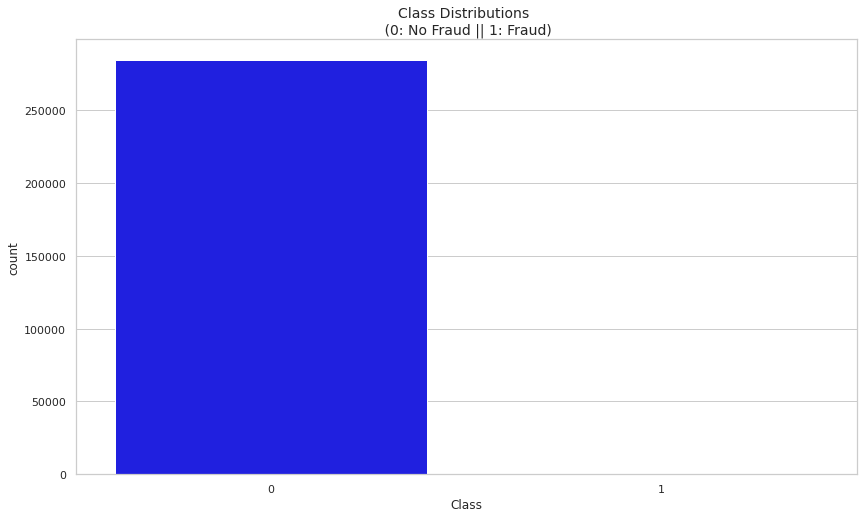

In [ ]:
colors = ['Blue', 'Orange']

sns.countplot('Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

Yup... Definitely skewed.

Let's have a look at the distributions:

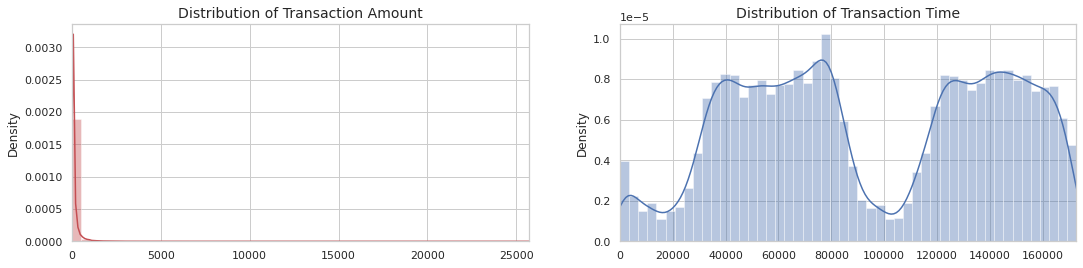

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

# Scaling and Distribution

**Scaling**: We will be scaling the columns **Time** and **Amount**.

**Distributing**: We will create a subsample of the dataframe in order to have an equal amount of Fraud and Non-Fraud cases. This will help our algorithm better understand patterns that determines whether a transaction is a fraud or not.

The subsample will be a dataframe with a 50/50 ratio of fraud and non-fraud transactions. This is important to avoid overfitting and give us the correct correlations between the features.

We need to randomly choose 492 cases from the non-fraud transactions and placed them in our new dataframe.

Most of our data is already scaled, so we only need to scale the **Time** and **Amount** features:

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True) # removing non-scaled time and
# amount from the dataframe

In [ ]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True) # remove from end
df.insert(0, 'scaled_amount', scaled_amount) # place scaled amount at column 1
df.insert(1, 'scaled_time', scaled_time) # place scaled time at column 2

# Amount and Time are now scaled!

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


## Splitting the Data

Before we do **Random Undersampling**, we have to create our testing set from the original dataframe so that we can test our model created from the undersampled dataframe on the original dataframe's test set.

In [ ]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df)*100, 2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df)*100, 2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in skf.split(X, y):
  print("Train:", train_index, "Test:", test_index)
  original_X_train, original_X_test = X.iloc[train_index], X.iloc[test_index]
  original_y_train, original_y_test = y.iloc[train_index], y.iloc[test_index]

# Turn into an array
original_X_train = original_X_train.values
original_X_test = original_X_test.values
original_y_train = original_y_train.values
original_y_test = original_y_test.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_y_train, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_y_test, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_y_train))
print(test_counts_label/ len(original_y_test))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


# Random Undersample and Oversampling

Let's balance our dataset by using random undersampling!

Steps:

1. Determine how imbalanced our class is. **value_count()** applied to **Class** works well for this. In our case, this is 492.
2. Bring the number of non-fraud transactions to the same as fraud transactions.
3. *Shuffle the data** to see if our model can maintain a certain accuracy everytime we run our script.

Obviously, there is an issue with this method: because we are removing so many transactions, our dataset decreases in size significantly and there is information loss.

Let's shuffle the data before creating subsamples:

In [ ]:
df = df.sample(frac=1)

# amount of fraud classes
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
283202,-0.195766,1.019150,0.564803,0.926989,-0.076971,1.052468,0.409504,-0.712611,0.780940,-0.384619,...,0.222194,0.451322,1.626926,-0.084080,0.019414,-1.126709,0.132318,0.345509,0.285020,0
95597,18.615944,-0.226824,-2.923827,1.524837,-3.018758,3.289291,-5.755542,2.218276,-0.509995,-3.569444,...,-0.447039,-0.511657,-0.122724,-4.288639,0.563797,-0.949451,-0.204532,1.510206,-0.324706,1
57295,0.082303,-0.432876,-0.392327,0.002672,1.827241,-1.748195,-0.911846,-0.536602,0.067686,0.165427,...,-0.109092,0.204977,0.811966,-0.172019,0.443257,0.007597,0.129047,0.089211,0.056349,0
83417,-0.224831,-0.291968,-3.215382,-0.364223,-1.261883,3.794949,0.711206,-1.316476,-5.165141,0.625278,...,0.019626,0.401341,0.152191,-0.934675,-0.256148,-0.469403,-0.282496,0.866077,-0.433466,1
151011,-0.293440,0.113629,-15.192064,10.432528,-19.629515,8.046075,-12.838167,-1.875859,-21.359738,-3.717850,...,1.657476,-3.474097,1.765446,1.701257,0.381587,-1.413417,-1.023078,-2.634761,-0.463931,1


## Equally Distributing and Correlating:

Distribution of the Classes in the subsample dataset
0    0.5
1    0.5
Name: Class, dtype: float64


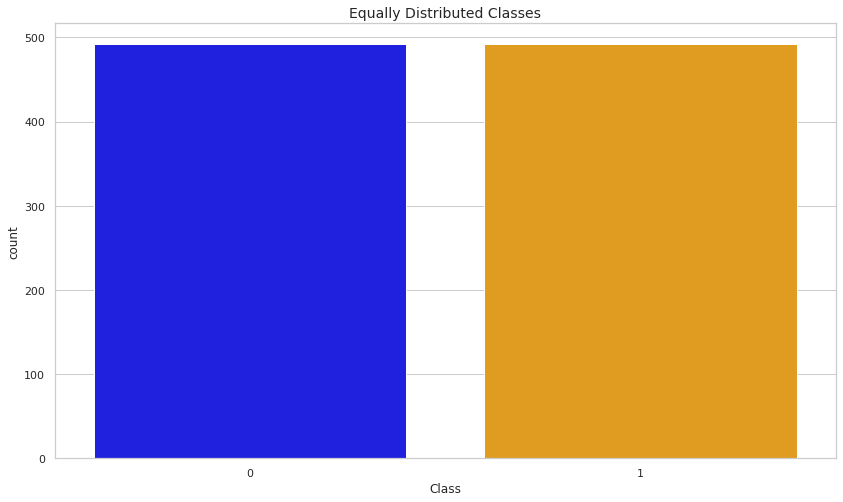

In [ ]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df)) # percentage for each class

sns.countplot('Class', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

Perfect, we have a 50/50 split!

### Correlation Matrices

If we want to understand our data, correlation matrices can help us tremendously. This will help us learn which features heavily influence whether a specific transaction is a fraud. We are only using a correlation matrices now, after we've subsampled the dataframe and created an even 50/50 split. If we would have done it with the original dataset, we would not have seen the correlations in the context that we care about.

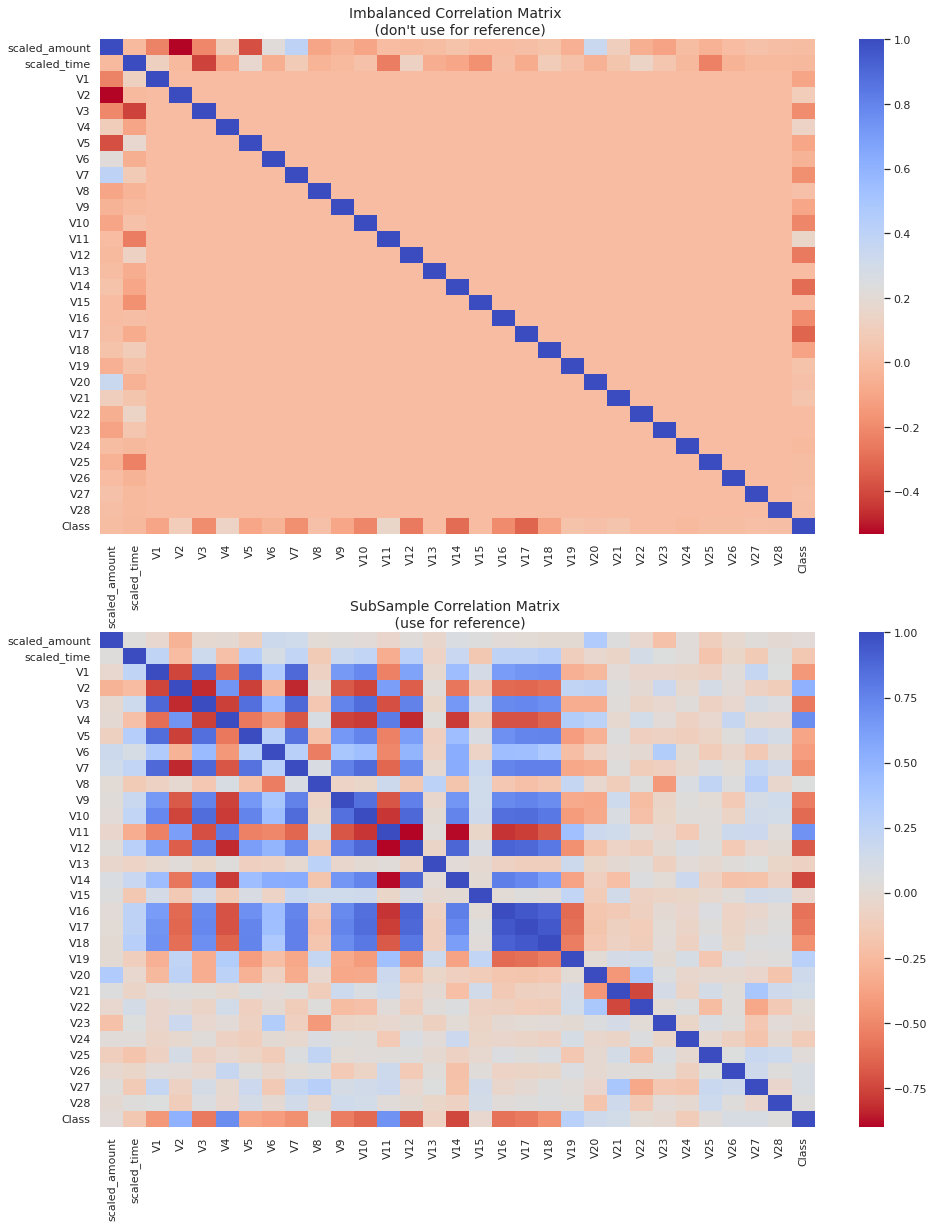

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 20))

# Entire DataFrame (to show how the correlation looks like in an imbalanced dataset)
corr = df.corr() # calculate correlation between features
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

# Subsampled DataFrame
sub_sample_corr = new_df.corr() # calculate correlation between features
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title("SubSample Correlation Matrix \n (use for reference)", fontsize=14)
plt.show()

The visual is nice, but let's see which ones are the most positively and negatively correlated in text format:

In [ ]:
sol = (sub_sample_corr.where(np.triu(np.ones(sub_sample_corr.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))

print(sol[0:9])
print(sol[-9:-1])

V16  V17    0.948927
V17  V18    0.941649
V16  V18    0.906426
V12  V16    0.895683
     V14    0.881670
V3   V7     0.880527
V10  V12    0.878448
V12  V17    0.878205
V1   V3     0.875961
dtype: float64
V4   V10   -0.782406
     V14   -0.785983
V10  V11   -0.796577
V11  V16   -0.806023
V2   V3    -0.826606
V4   V12   -0.828619
V2   V7    -0.836634
V11  V14   -0.889561
dtype: float64


In [ ]:
print(sub_sample_corr['Class'].sort_values(ascending=False))

Class            1.000000
V4               0.704455
V11              0.684956
V2               0.502887
V19              0.282662
V20              0.151730
V21              0.126979
V26              0.094013
V27              0.089556
V8               0.051379
V28              0.039753
V25              0.021045
scaled_amount    0.016713
V22              0.010563
V23             -0.012279
V15             -0.029302
V13             -0.088682
V24             -0.129284
scaled_time     -0.164015
V5              -0.369857
V6              -0.408739
V1              -0.429008
V18             -0.468037
V7              -0.474535
V9              -0.544664
V17             -0.562849
V3              -0.565439
V16             -0.592777
V10             -0.626900
V12             -0.684624
V14             -0.744665
Name: Class, dtype: float64


We can see from the output which variables are positively and negatively correlated strongly. Some of these are highly correlated.

Now, if we look at the bottom of the second figure, we can see the correlation between the features and the class (fraud or not fraud). We are able to make out the following:

V2, V4, V11, and V19 are all very positively correlated with the class. This means that the higher the value for one of these features, the more likely it will be a fraud transaction.

V10, V12, V14, and V16 are all very negatively correlated with the class. This means that the lower the value for one of these features, the more likely it will be a fraud transaction.

Let's use boxplots to get a better understanding of the distribution of these 8 features in fraudulent and non fraudulent transactions:

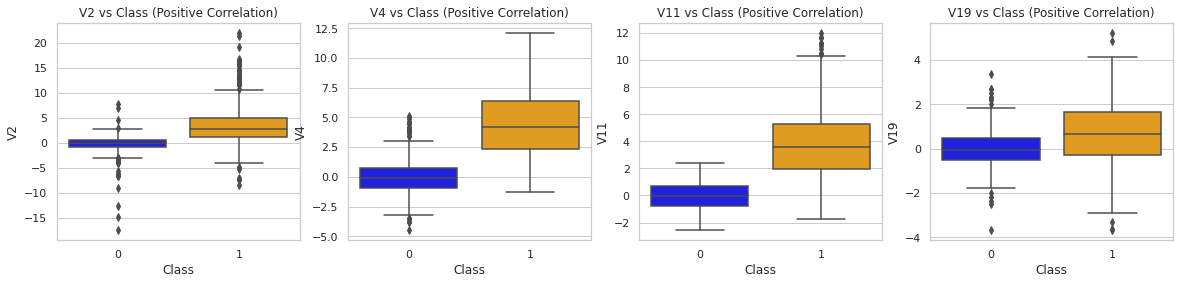

In [ ]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Creating the boxplot
sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V2 vs Class (Positive Correlation)')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class (Positive Correlation)')

sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V11 vs Class (Positive Correlation)')

sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class (Positive Correlation)')

plt.show()

We can see that the features selected here have a statistically higher value when there is a fraudulent transaction. We don't know what these features actually mean, but we (at least) have somewhat of an understanding of their correlation with the class. This can be very useful when we are further preparing our dataset for our model.

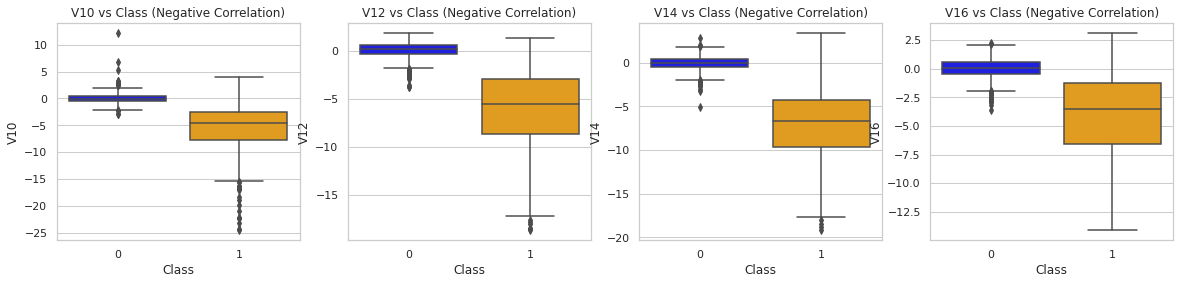

In [ ]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Creating the boxplot (negative correlation)
sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V10 vs Class (Negative Correlation)')

sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V12 vs Class (Negative Correlation)')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V14 vs Class (Negative Correlation)')

sns.boxplot(x="Class", y="V16", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V16 vs Class (Negative Correlation)')

plt.show()

We can see that the features selected here have a statistically lower value (in the negative numbers) when there is a fraudulent transaction.

Figure to better understand boxplots:

![Image](https://discourse-cdn-sjc1.com/business6/uploads/analyticsvidhya/original/2X/d/d11281b44c2e440b36aaf29156b5032105d2d06b.png)

## Anomaly Detection

Now that we now which are the features with the highest correlation with our classes, we will be removing the extreme outliers from those features in order to improve the accuracy of our models.

We will do this by using the **Interquartile Range Method**. Essentially, we will create a threshold beyond the lower/upper extremes (25th and 75th percentiles), and any value that passes that threshold will be removed from our dataset.

To get our threshold for removing "extreme outliers:, we will multiply the interquartile range by a number we will judge as reasonable. Of course, there is a tradeoff here when deciding where to place the thresold. If we put it too far from the extremes, we may end up including "extreme" outliers in the dataset. If we are too close from the extremes, then we risk removing "normal" outliers.

We can always come back and play with the threshold to see how it affects our classification models. 

**Summary of the next steps**:

*   **Visualize Distributions**: We'll start by visualizing the distribution of the features we are going to use to eliminate outliers.
*   **Determiner the threshold**: We will calculate the threshold based on the multiplier we've decided on.
*   **Conditional Dropping**: We will drop any values that pass the threshold.
*   **Boxplot Representation**: We will finally visualize the boxplot to see how much it has changed now that we have removed the "extreme outliers".



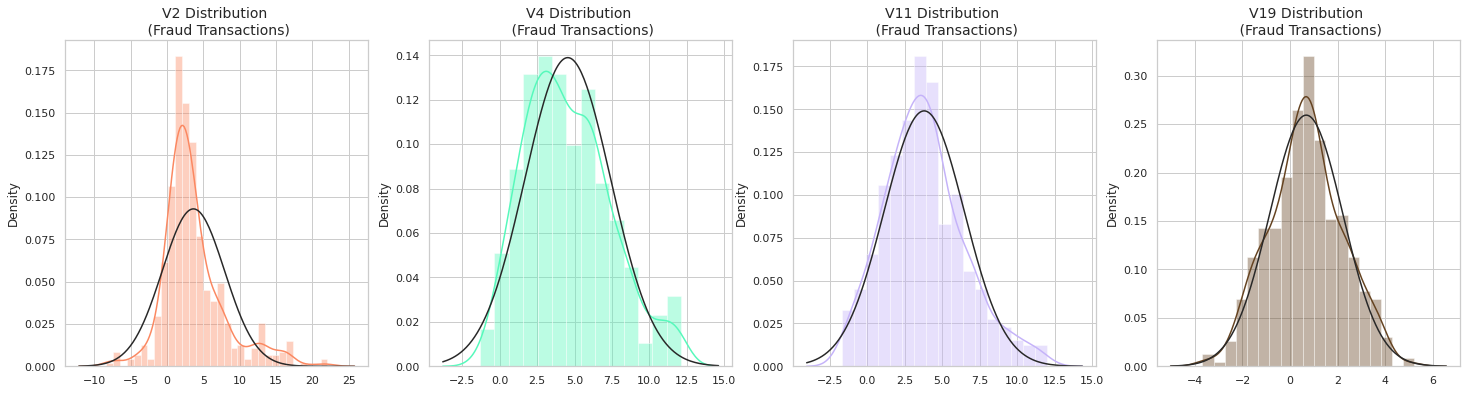

In [ ]:
from scipy.stats import norm

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25, 6))

V2_fraud_dist = new_df['V2'].loc[new_df['Class'] == 1].values
sns.distplot(V2_fraud_dist, ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V2 Distribution \n (Fraud Transactions)', fontsize=14)

v4_fraud_dist = new_df['V4'].loc[new_df['Class'] == 1].values
sns.distplot(v4_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V4 Distribution \n (Fraud Transactions)', fontsize=14)


v11_fraud_dist = new_df['V11'].loc[new_df['Class'] == 1].values
sns.distplot(v11_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V11 Distribution \n (Fraud Transactions)', fontsize=14)

v19_fraud_dist = new_df['V19'].loc[new_df['Class'] == 1].values
sns.distplot(v19_fraud_dist,ax=ax4, fit=norm, color='#654321')
ax4.set_title('V19 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

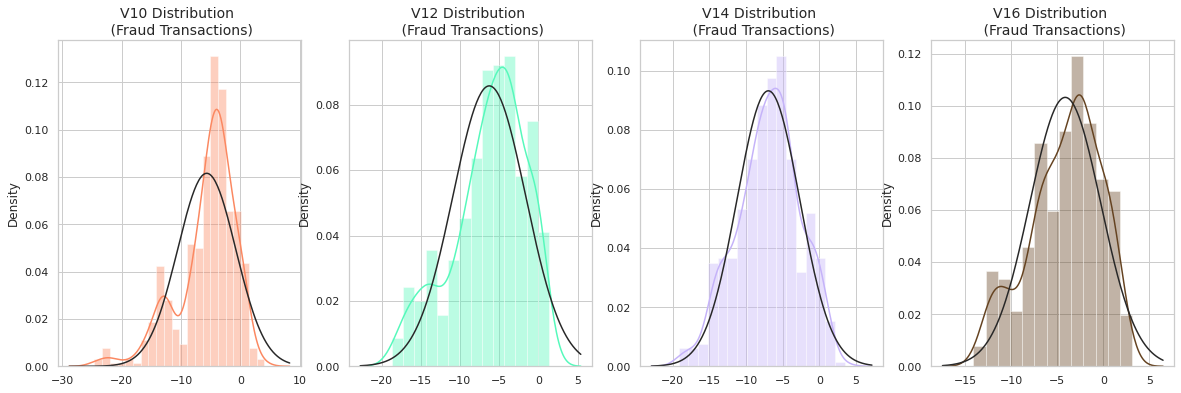

In [ ]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 6))

V10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(V10_fraud_dist, ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v16_fraud_dist = new_df['V16'].loc[new_df['Class'] == 1].values
sns.distplot(v16_fraud_dist,ax=ax4, fit=norm, color='#654321')
ax4.set_title('V16 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

We will now remove the extreme outliers from some of the features:

In [ ]:
multiplier_for_threshold = 1.5

# -----> V14
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * multiplier_for_threshold
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

# check in V14 to find extreme outliers; the ones who pass the threshold
outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('V14 outliers:{}'.format(outliers))
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)

# -----> V12
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v12_iqr = q75 - q25
print('iqr: {}'.format(v12_iqr))

v12_cut_off = v12_iqr * multiplier_for_threshold
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))

new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# -----> V10
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v10_iqr = q75 - q25
print('iqr: {}'.format(v10_iqr))

v10_cut_off = v10_iqr * multiplier_for_threshold
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))

new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)

# # -----> V4
# v4_fraud = new_df['V4'].loc[new_df['Class'] == 1].values
# q25, q75 = np.percentile(v4_fraud, 25), np.percentile(v4_fraud, 75)
# print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
# v4_iqr = q75 - q25
# print('iqr: {}'.format(v4_iqr))

# v4_cut_off = v4_iqr * multiplier_for_threshold
# v4_lower, v4_upper = q25 - v4_cut_off, q75 + v4_cut_off
# print('Cut Off: {}'.format(v4_cut_off))
# print('V4 Lower: {}'.format(v4_lower))
# print('V4 Upper: {}'.format(v4_upper))

# outliers = [x for x in v4_fraud if x < v4_lower or x > v4_upper]
# print('V4 outliers:{}'.format(outliers))
# print('Feature V4 Outliers for Fraud Cases: {}'.format(len(outliers)))
# print('----' * 44)

# # -----> V2
# v2_fraud = new_df['V2'].loc[new_df['Class'] == 1].values
# q25, q75 = np.percentile(v2_fraud, 25), np.percentile(v2_fraud, 75)
# print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
# v2_iqr = q75 - q25
# print('iqr: {}'.format(v2_iqr))

# v2_cut_off = v2_iqr * multiplier_for_threshold
# v2_lower, v2_upper = q25 - v12_cut_off, q75 + v2_cut_off
# print('V2 Lower: {}'.format(v2_lower))
# print('V2 Upper: {}'.format(v2_upper))
# outliers = [x for x in v2_fraud if x < v2_lower or x > v2_upper]
# print('V2 outliers: {}'.format(outliers))
# print('Feature V2 Outliers for Fraud Cases: {}'.format(len(outliers)))
# print('----' * 44)

# # -----> V11
# v11_fraud = new_df['V11'].loc[new_df['Class'] == 1].values
# q25, q75 = np.percentile(v11_fraud, 25), np.percentile(v11_fraud, 75)
# print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
# v11_iqr = q75 - q25
# print('iqr: {}'.format(v11_iqr))

# v11_cut_off = v11_iqr * multiplier_for_threshold
# v11_lower, v11_upper = q25 - v11_cut_off, q75 + v11_cut_off
# print('Cut Off: {}'.format(v11_cut_off))
# print('V11 Lower: {}'.format(v11_lower))
# print('V11 Upper: {}'.format(v11_upper))

# # check in V14 to find extreme outliers; the ones who pass the threshold
# outliers = [x for x in v11_fraud if x < v11_lower or x > v11_upper]
# print('V11 outliers:{}'.format(outliers))
# print('Feature V11 Outliers for Fraud Cases: {}'.format(len(outliers)))

Quartile 25: -9.692722964972386 | Quartile 75: -4.282820849486865
iqr: 5.409902115485521
Cut Off: 8.114853173228282
V14 Lower: -17.807576138200666
V14 Upper: 3.8320323237414167
V14 outliers:[-18.4937733551053, -19.2143254902614, -18.8220867423816, -18.0499976898594]
Feature V14 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 980
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Quartile 25: -8.67303320439115 | Quartile 75: -2.893030568676315
iqr: 5.780002635714835
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.5536970096458, -18.6837146333443, -18.4311310279993, -18.0475965708216]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 976
-----------------------------------------------------------------------------------------------------------------------------------------------

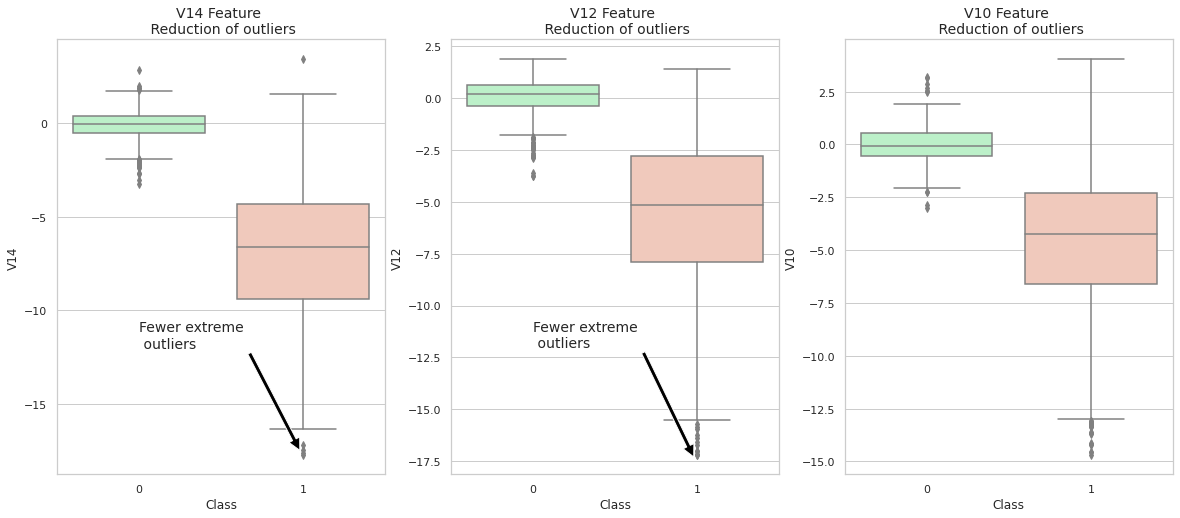

In [ ]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,8))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

plt.show()

## Dimensionality Reduction and Clustering

We will be using three different types of dimensionality reduction techniques and pick out the best one before we move on. The three techniques are:

*   t-SNE
*   PCA (Principal Component Analysis)
*   Truncated SVD (Singular Value Decomposition)

### Understanding t-SNE:

t-SNE takes a high-dimensional dataset and reduces it to a low-dimensional graph that retains a lot of the original information.

t-SNE measures the euclidean distance between two points and then plots that distance on a normal curve that is centered on the point of interest. Lastly, it takes the distance between point 2 and where it is on the normal curve.

![t-SNE image](https://i.imgur.com/aRejNDp.png)

This length is the "unscaled similarity". We calculate this length for all of the points.

In order to take into account the density of similar points, t-SNE will scale these lengths so that the sum of all lengths equals 1. You now have a similarity matrix.

Now, you "randomly project" all the points to a lower dimensionality. You calculate the similarity scores for all the points again, but in this lower dimensionality and with a "t-shaped" distribution (which I will explain why in a second). You end up a matrix that is quite random and different from the first one you created. t-SNE will now take small steps to bring together the similar points and, in turn, make your new similarity matrix closer to the first one it created. The "t-shaped" distribution causes the groups of points to separate as much as possible so that it can tell them apart. Without the t-shaped distribution, the points would all clump up together in the middle.

After looking at the graphs, I won't bother explaining PCA and Truncated SVD since we will be moving forward with t-SNE.

In [ ]:
# let's update our inputs and outputs
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# t-SNE
t0 = time.time() # for calculating the time it takes to do t-SNE
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print('t-SNE took {:.2} s'.format(t1 - t0))

# PCA
t0 = time.time() # for calculating the time it takes to do t-SNE
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print('PCA took {:.2} s'.format(t1 - t0))

# Truncated SVD (basically PCA but for sparse data)
t0 = time.time() # for calculating the time it takes to do t-SNE
X_reduced_svd = TruncatedSVD(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print('Truncated SVD took {:.2} s'.format(t1 - t0))

t-SNE took 9.0 s
PCA took 0.0081 s
Truncated SVD took 0.0082 s


Now that we've reduced the dimensionality to 2D, let's plot the result:

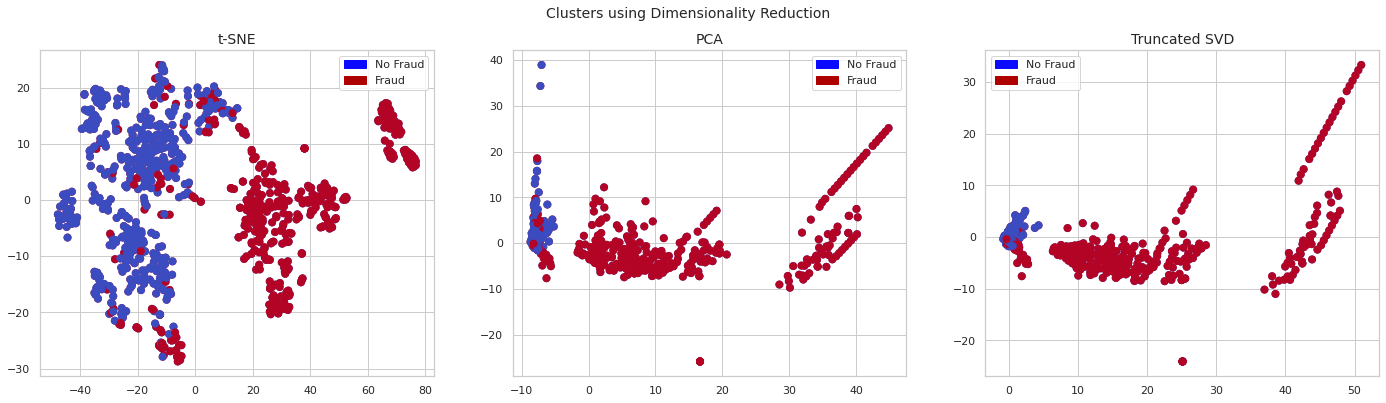

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

We can see that t-SNE has way more No Fraud points than the other two. It seems much more even (our 50/50 split) with t-SNE so we will be going forward with t-SNE.

## Classifiers (UnderSampling)

In this section, we will train and test two classifiers and decide which one we want to move forward with. The classifiers we will be testing are the following:

*   Logistic Regression
*   xgboost

In [ ]:
# let's update our inputs and outputs
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# Let's split our data in training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Turn values into an array for feeding the classifications algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

We'll now use GridSearchCV to test out the algorithms.

In [ ]:
from xgboost import XGBClassifier

# Use GridSearchCV to find the best paramaters.
from sklearn.model_selection import GridSearchCV

# Logistic Regression
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

# xgboost
xgboost_params = {'objective': ["binary:logistic"]
      , 'eta': [0.01, 0.1, 0.2, 0.3]
			, 'max_depth': [3, 6, 9]
			, 'min_child_weight': [1, 10, 100, 1000]
			, 'eval_metric': ["auc"]
      }

grid_xgboost = GridSearchCV(XGBClassifier(), xgboost_params)
grid_xgboost.fit(X_train, y_train)
# We automatically get the xgboost regression with the best parameters.
xgboost_model = grid_xgboost.best_estimator_

In [ ]:
print(log_reg)
print(xgboost_model)

# LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
#                    intercept_scaling=1, l1_ratio=None, max_iter=100,
#                    multi_class='warn', n_jobs=None, penalty='l1',
#                    random_state=None, solver='warn', tol=0.0001, verbose=0,
#                    warm_start=False)
# XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=1, eta=0.01,
#               eval_metric='auc', gamma=0, learning_rate=0.1, max_delta_step=0,
#               max_depth=6, min_child_weight=10, missing=None, n_estimators=100,
#               n_jobs=1, nthread=None, objective='binary:logistic',
#               random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
#               seed=None, silent=None, subsample=1, verbosity=1)

LogisticRegression(C=0.1)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='auc',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=10, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)


In [ ]:
from sklearn.model_selection import cross_val_score

# Overfitting Case

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', 
      round(log_reg_score.mean() * 100, 2).astype(str) + '%')

xgboost_score = cross_val_score(xgboost_model, X_train, y_train, cv=5)
print('XGBoost Cross Validation Score: ', 
      round(xgboost_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  93.65%
XGBoost Cross Validation Score:  93.65%


Now, let's undersample during cross validation:

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

sss = StratifiedKFold(n_splits=5, shuffle=False)

for train_index, test_index in sss.split(undersample_X, undersample_y):
  print("Train:", train_index, "Test:", test_index)
  undersample_X_train, undersample_X_test = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
  undersample_y_train, undersample_y_test = undersample_y.iloc[train_index], undersample_y.iloc[test_index]

undersample_X_train = undersample_X_train.values
undersample_X_test = undersample_X_test.values
undersample_y_train = undersample_y_train.values
undersample_y_test = undersample_y_test.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels; we won't use these variables)
X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))

# Cross Validating the right way

for train, test in sss.split(undersample_X_train, undersample_y_train):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_X_train[train], undersample_y_train[train])
    undersample_prediction = undersample_model.predict(undersample_X_train[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_X_train[test], original_y_train[test]))
    undersample_precision.append(precision_score(original_y_train[test], undersample_prediction))
    undersample_recall.append(recall_score(original_y_train[test], undersample_prediction))
    undersample_f1.append(f1_score(original_y_train[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_y_train[test], undersample_prediction))

Train: [ 54854  55766  56437 ... 284804 284805 284806] Test: [    0     1     2 ... 56963 56964 56965]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 54854  55766  56437 ... 113924 113925 113926]
Train: [     0      1      2 ... 284804 284805 284806] Test: [113258 113448 113797 ... 170884 170885 170886]
Train: [     0      1      2 ... 284804 284805 284806] Test: [169363 170667 170887 ... 229804 229888 230362]
Train: [     0      1      2 ... 229804 229888 230362] Test: [227839 227840 227841 ... 284804 284805 284806]
NearMiss Label Distribution: Counter({0: 492, 1: 492})


In [ ]:
# Let's Plot LogisticRegression Learning Curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    
    # Logistic Regression
    train_sizes, train_scores, test_scores = learning_curve(estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124", label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff", label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")

    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

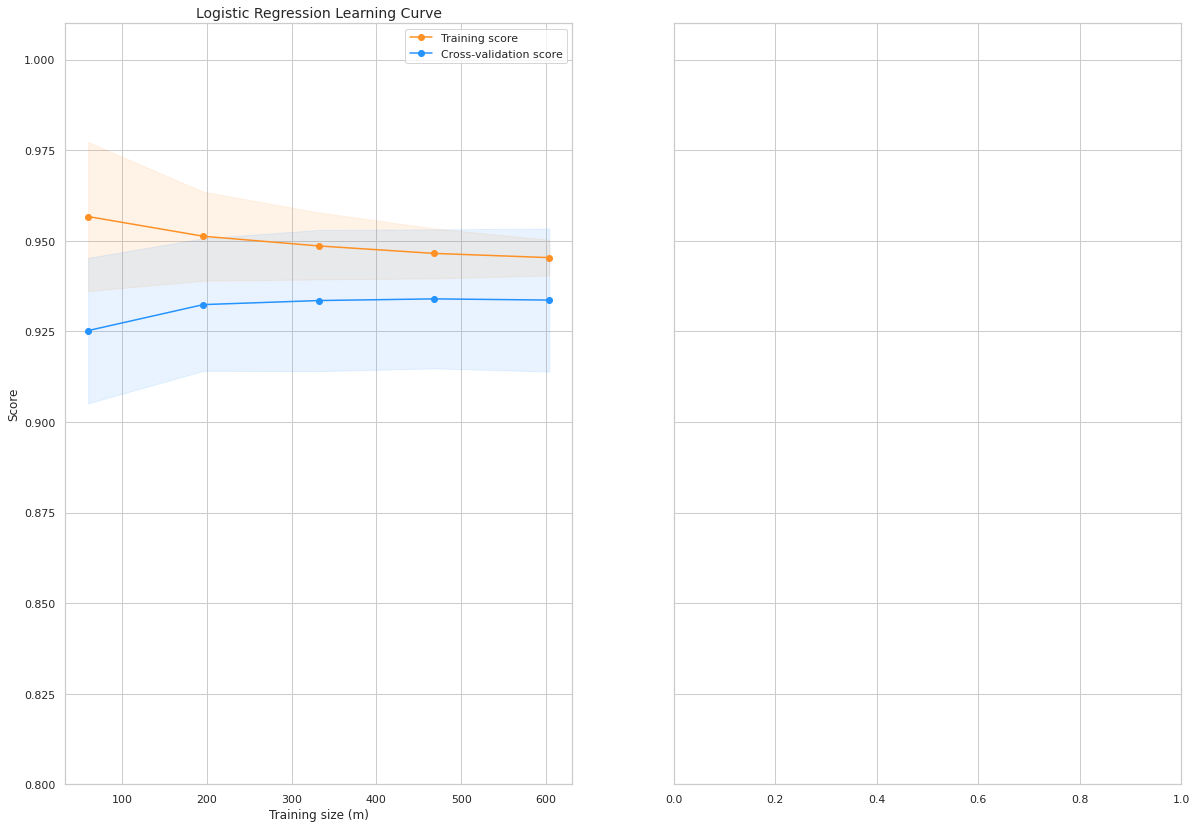

In [ ]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, X_train, y_train, (0.8, 1.01), cv=cv, n_jobs=4)

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

In [ ]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))

Logistic Regression:  0.9756249868442287


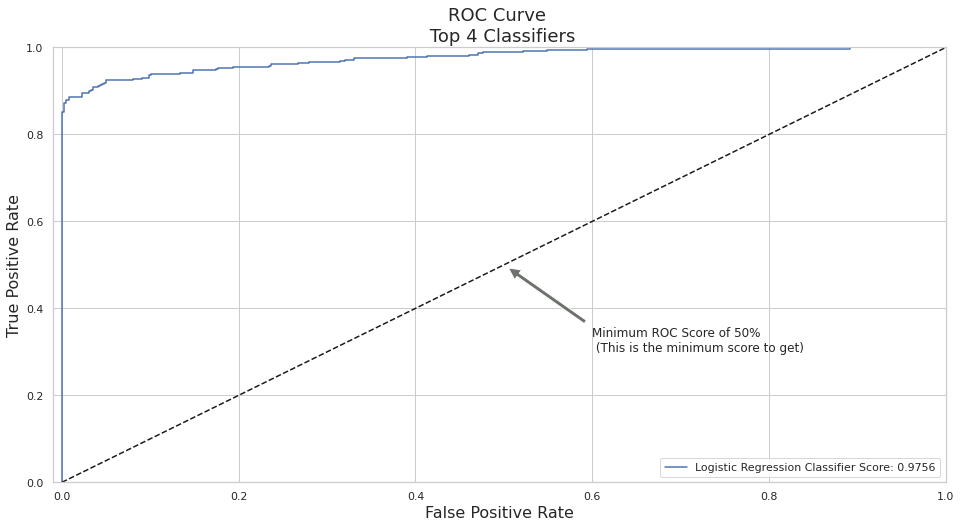

In [ ]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)

def graph_roc_curve_multiple(log_fpr, log_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot([0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr)
plt.show()

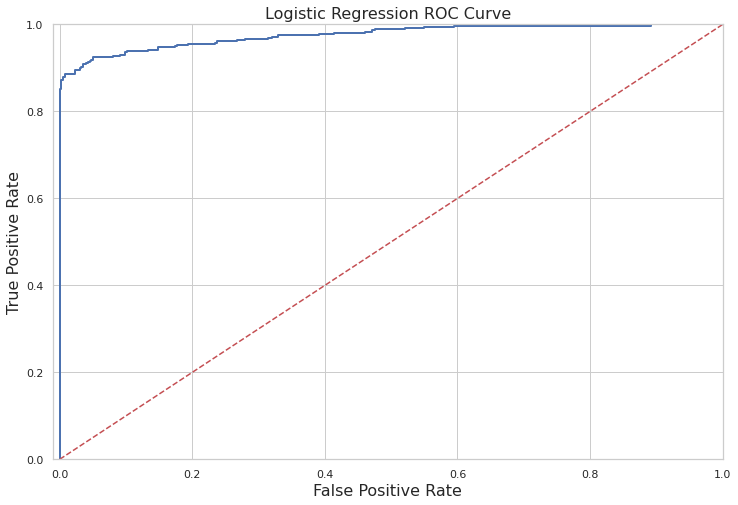

In [ ]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
    
logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)

In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
y_pred = log_reg.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.91
Precision Score: 0.71
F1 Score: 0.80
Accuracy Score: 0.78
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.77
Precision Score: 0.00
Recall Score: 0.21
F1 Score: 0.00
---------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
undersample_y_score = log_reg.decision_function(original_X_test)

In [ ]:
from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(original_y_test, 
                                                        undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      undersample_average_precision))

Average precision-recall score: 0.07


Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score =0.07')

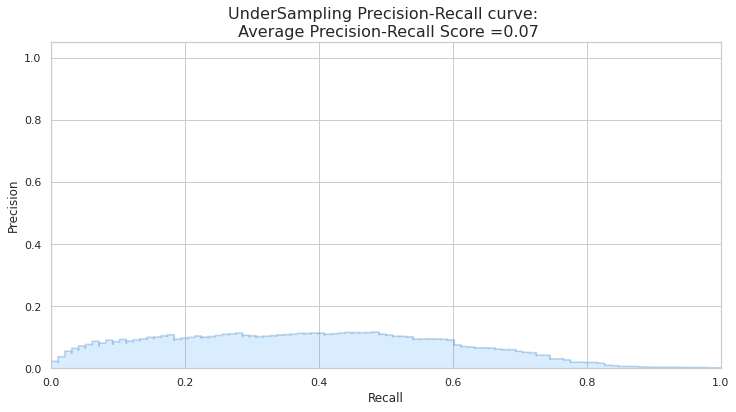

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_y_test, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          undersample_average_precision), fontsize=16)

In [ ]:
# Final Score in the test set of logistic regression
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)

d = {'Technique': ['Random UnderSampling'], 
     'Score': [undersample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

# Note how high is accuracy score it can be misleading! 
final_df

#0.798942

,Technique,Score
0,Random UnderSampling,0.831579
